# Projet : Détection de Chats par Vision Artificielle

**Module** : Vision par Ordinateur  
**Membres du groupe** :
- AKAKPO Mathieu
- MINTSA-MI OBAME Dimitri
- AGBEVIADE Joachim

**Date** : 4 janvier 2026

## Résumé du Projet

Ce projet implémente un modèle de détection d'objets pour identifier les chats dans des images contenant divers éléments (chiens, humains, autres objets).  
L'approche repose sur un modèle pré-entraîné avec transfert learning, conformément aux consignes du travail pratique.

## Objectif

L'objectif principal consiste à mettre en pratique les techniques de détection d'objets sur un dataset adapté.  
Le modèle détecte et localise les chats via des bounding boxes, tout en distinguant cette classe des autres entités présentes.

## Choix du Dataset

Deux sources de données ont été combinées pour construire un dataset adapté à la tâche :

- **Oxford-IIIT Pet Dataset** (≈ 7 400 images)  
  Dataset public annoté contenant 37 races de chats et chiens.  
  Adaptation réalisée : regroupement de toutes les races de chats en une seule classe « chat » ; extraction séparée des images de chiens pour les utiliser comme exemples négatifs (faux positifs potentiels).

- **Extraits du dataset MS COCO**  
  Images additionnelles contenant uniquement des humains et des scènes sans animaux (aucun chat ni chien).  
  Objectif : renforcer la capacité du modèle à rejeter les humains et les contextes non pertinents, et réduire les confusions fréquentes.

Cette combinaison assure une variété suffisante en poses, échelles, éclairages et occlusions, tout en permettant au modèle de mieux discriminer les chats des autres entités courantes.

## Étude Comparative des Modèles

Une analyse comparative a porté sur trois architectures principales : YOLOv8, Faster R-CNN et RetinaNet.

| Critère                  | YOLOv8      | Faster R-CNN | RetinaNet   |
|--------------------------|-------------|--------------|-------------|
| Vitesse (FPS)            | 120-150    | 8-12        | 25-30      |
| Précision générale       | Très bonne | Excellente  | Bonne      |
| Taille du modèle         | 6-50 MB    | 200+ MB     | 90-150 MB  |
| Facilité d’utilisation   | Très facile| Complexe    | Moyenne    |
| Détection petits objets  | Bonne      | Excellente  | Très bonne |
| Robustesse aux occlusions| Bonne      | Excellente  | Moyenne    |
| Mémoire GPU requise      | 1-2 GB     | 3-4 GB      | 2-3 GB     |

Recommandations par cas d'usage :  
- Applications temps réel → YOLOv8  
- Précision maximale → Faster R-CNN  

## Justification du Choix du Modèle

Faster R-CNN constitue le modèle retenu pour ce projet.  
Cette architecture deux étapes (génération de propositions de régions suivie de classification) offre une précision supérieure, particulièrement adaptée à la détection de petits objets et aux occlusions fréquentes dans les images d'animaux.  
Dans le contexte pédagogique du projet, l'absence de contrainte stricte en temps réel permet de privilégier la précision sur la vitesse.  
Faster R-CNN reste une référence académique pour les benchmarks de détection d'objets.  
Les ressources de calcul disponibles supportent sans difficulté l'entraînement et l'inférence de ce modèle.  
Bien que YOLOv8 excelle en déploiement temps réel, Faster R-CNN maximise la valeur éducative en illustrant les fondamentaux des détecteurs deux étapes.

## Approche Technique Globale

Implémentation basée sur la bibliothèque TorchVision de PyTorch.  
Modèle de base : Faster R-CNN avec backbone ResNet-50-FPN V2 pré-entraîné sur COCO.  
Adaptation via transfert learning : remplacement de la tête de classification pour 2 classes (background + chat).  
Ajout de données complémentaires issues de COCO (images d’humains et scènes sans animaux) pour renforcer la discrimination et réduire les faux positifs.  
Évaluation des performances via les métriques : précision, rappel, F1-score et IoU moyen (par seuil de confiance).

La suite du code couvrira le chargement des données, la préparation du dataset, l'entraînement, l'évaluation et l'inférence.

## 1. Configuration de l'Environnement

### 1.1 Vérification des Ressources de Calcul

In [ ]:
import torch

# Affichage de la version de PyTorch
print(f"Version de PyTorch : {torch.__version__}")

# Détection de la présence d'un GPU compatible CUDA
gpu_available = torch.cuda.is_available()
print(f"GPU disponible (CUDA) : {gpu_available}")

if gpu_available:
    device_name = torch.cuda.get_device_name(0)
    total_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    device_count = torch.cuda.device_count()
    print(f"Nom du GPU principal : {device_name}")
    print(f"Mémoire totale du GPU : {total_memory_gb:.2f} GB")
    print(f"Nombre de GPUs détectés : {device_count}")
else:
    print("Aucun GPU détecté. Le calcul s'effectuera sur CPU.")

# Définition du dispositif utilisé pour les tenseurs et le modèle
device = torch.device("cuda:0" if gpu_available else "cpu")
print(f"Dispositif sélectionné : {device}")

Version de PyTorch : 2.6.0
GPU disponible (CUDA) : True
Nom du GPU principal : Tesla T4
Mémoire totale du GPU : 15.64 GB
Nombre de GPUs détectés : 1
Dispositif sélectionné : cuda:0


### 1.2 Importation des Bibliothèques

In [ ]:
!pip install --quiet --upgrade \
    albumentations==1.4.3 \
    torchmetrics==1.4.0 \
    opencv-python-headless \
    tqdm

In [ ]:
# Bibliothèques standard
import os
import json
import random
import warnings
from pathlib import Path

# Bibliothèques numériques et traitement de données
import numpy as np
import pandas as pd

# Bibliothèques de visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# PyTorch et modules associés
import torch
from torch.utils.data import Dataset, DataLoader

# TorchVision pour les modèles de détection
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Albumentations pour les augmentations d'images compatibles avec la détection
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Gestion des avertissements
warnings.filterwarnings("ignore")

# Configuration globale de matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = False

## 2. Acquisition et Préparation du Dataset

### 2.1 Téléchargement du Dataset Oxford-IIIT Pet

Cette section télécharge et extrait le dataset Oxford-IIIT Pet depuis les sources officielles.

In [ ]:
from pathlib import Path

# URLs des archives du dataset
dataset_urls = {
    'images': 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
    'annotations': 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz'
}

def telecharger_et_extraire():
    """Télécharge et extrait les archives si elles n'existent pas localement."""
    for nom, url in dataset_urls.items():
        fichier_archive = Path(f"{nom}.tar.gz")
        if not fichier_archive.exists():
            print(f"Téléchargement de {nom} depuis {url}")
            os.system(f"wget -q {url} -O {fichier_archive}")
            print(f"Extraction de {fichier_archive.name}")
            os.system(f"tar -xzf {fichier_archive}")
            print(f"{nom} prêt")
        else:
            print(f"{nom} déjà présent localement")

# Exécution du téléchargement et de l'extraction
telecharger_et_extraire()

Téléchargement de images depuis https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Extraction de images.tar.gz
images prêt
Téléchargement de annotations depuis https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Extraction de annotations.tar.gz
annotations prêt


### 2.2 Analyse de la Structure du Dataset

Le dataset contient des images et des annotations. Cette étape charge le fichier de métadonnées list.txt pour identifier les espèces.

In [ ]:
# Chemins principaux du dataset
CHEMIN_ANNOTATIONS = Path('annotations')
CHEMIN_IMAGES = Path('images')
CHEMIN_XMLS = CHEMIN_ANNOTATIONS / 'xml'

# Lecture du fichier list.txt
fichier_liste = CHEMIN_ANNOTATIONS / 'list.txt'

entrees = []
with open(fichier_liste, 'r') as f:
    for ligne in f:
        ligne = ligne.strip()
        if ligne and not ligne.startswith('#'):
            parties = ligne.split()
            if len(parties) >= 4:
                nom_image = parties[0]
                class_id = int(parties[1])
                species = int(parties[2])      # 1 = chat, 2 = chien
                breed_id = int(parties[3])
                entrees.append({
                    'nom_image': nom_image,
                    'class_id': class_id,
                    'species': species,
                    'breed_id': breed_id,
                    'est_chat': species == 1
                })

df_complet = pd.DataFrame(entrees)

# Statistiques globales
print("Statistiques du dataset complet")
print(f"Nombre total d'images : {len(df_complet)}")
print(f"Images de chats : {df_complet['est_chat'].sum()}")
print(f"Images de chiens : {(~df_complet['est_chat']).sum()}")
print(f"Nombre de races de chats : {df_complet[df_complet['est_chat']]['class_id'].nunique()}")

Statistiques du dataset complet
Nombre total d'images : 7349
Images de chats : 2371
Images de chiens : 4978
Nombre de races de chats : 12


### 2.3 Filtrage des Images de Chats

Seules les images de chats sont conservées pour la tâche de détection.

In [ ]:
df_chats = df_complet[df_complet['est_chat']].copy()
df_chats.reset_index(drop=True, inplace=True)

print(f"Nombre d'images de chats retenues : {len(df_chats)}")

print("\nDistribution par race de chat")
distribution_races = df_chats['class_id'].value_counts().sort_values(ascending=False)
for race_id, count in distribution_races.items():
    print(f"Race ID {race_id} : {count} images")

Nombre d'images de chats retenues : 2371

Distribution par race de chat
Race ID 6 : 200 images
Race ID 7 : 200 images
Race ID 21 : 200 images
Race ID 10 : 200 images
Race ID 34 : 200 images
Race ID 28 : 200 images
Race ID 24 : 200 images
Race ID 27 : 200 images
Race ID 33 : 199 images
Race ID 1 : 198 images
Race ID 12 : 190 images
Race ID 8 : 184 images


### 2.4 Parsing des Annotations XML

Le chemin correct pour les annotations XML dans le dataset Oxford-IIIT Pet est `annotations/xmls/`.

In [ ]:
import xml.etree.ElementTree as ET

CHEMIN_XMLS = CHEMIN_ANNOTATIONS / 'xmls'

def parser_annotation_xml(chemin_xml: Path):
    """Extrait les bounding boxes depuis un fichier XML du dataset Oxford-IIIT Pet (annotations tête).
    Note : ces XML n'ont pas de balise <size>, donc on ignore les dimensions."""
    if not chemin_xml.exists():
        return None

    try:
        tree = ET.parse(chemin_xml)
        root = tree.getroot()

        bboxes = []
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            if bndbox is not None:
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bboxes.append({
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'width': xmax - xmin,
                    'height': ymax - ymin
                })

        if not bboxes:
            return None

        return {
            'width': None,
            'height': None,
            'bboxes': bboxes
        }
    except Exception as e:
        return None

# Association des annotations aux images de chats
annotations_chats = []
total_images = len(df_chats)

for idx, row in df_chats.iterrows():
    nom_base = row['nom_image']
    chemin_xml = CHEMIN_XMLS / f"{nom_base}.xml"
    chemin_image = CHEMIN_IMAGES / f"{nom_base}.jpg"

    if chemin_xml.exists() and chemin_image.exists():
        annotation = parser_annotation_xml(chemin_xml)
        if annotation:
            annotations_chats.append({
                'nom_image': nom_base,
                'chemin_image': str(chemin_image),
                'chemin_xml': str(chemin_xml),
                'class_id': row['class_id'],
                'breed_id': row['breed_id'],
                'width': annotation['width'],
                'height': annotation['height'],
                'bboxes': annotation['bboxes'],
                'nb_bboxes': len(annotation['bboxes'])
            })

    if (idx + 1) % 500 == 0:
        print(f"{idx + 1}/{total_images} images traitées")

df_chats_annotes = pd.DataFrame(annotations_chats)

print(f"\nImages de chats avec annotations valides : {len(df_chats_annotes)}")
if len(df_chats_annotes) > 0:
    print(f"Bounding boxes totales : {df_chats_annotes['nb_bboxes'].sum()}")
    print(f"Moyenne de bounding boxes par image : {df_chats_annotes['nb_bboxes'].mean():.2f}")
else:
    print("Aucune annotation valide trouvée.")

500/2371 images traitées
1000/2371 images traitées
1500/2371 images traitées
2000/2371 images traitées

Images de chats avec annotations valides : 1181
Bounding boxes totales : 1182
Moyenne de bounding boxes par image : 1.00


### 2.5 Visualisation d'Échantillons Annotés

Quelques images sont affichées avec leurs bounding boxes pour vérification visuelle.

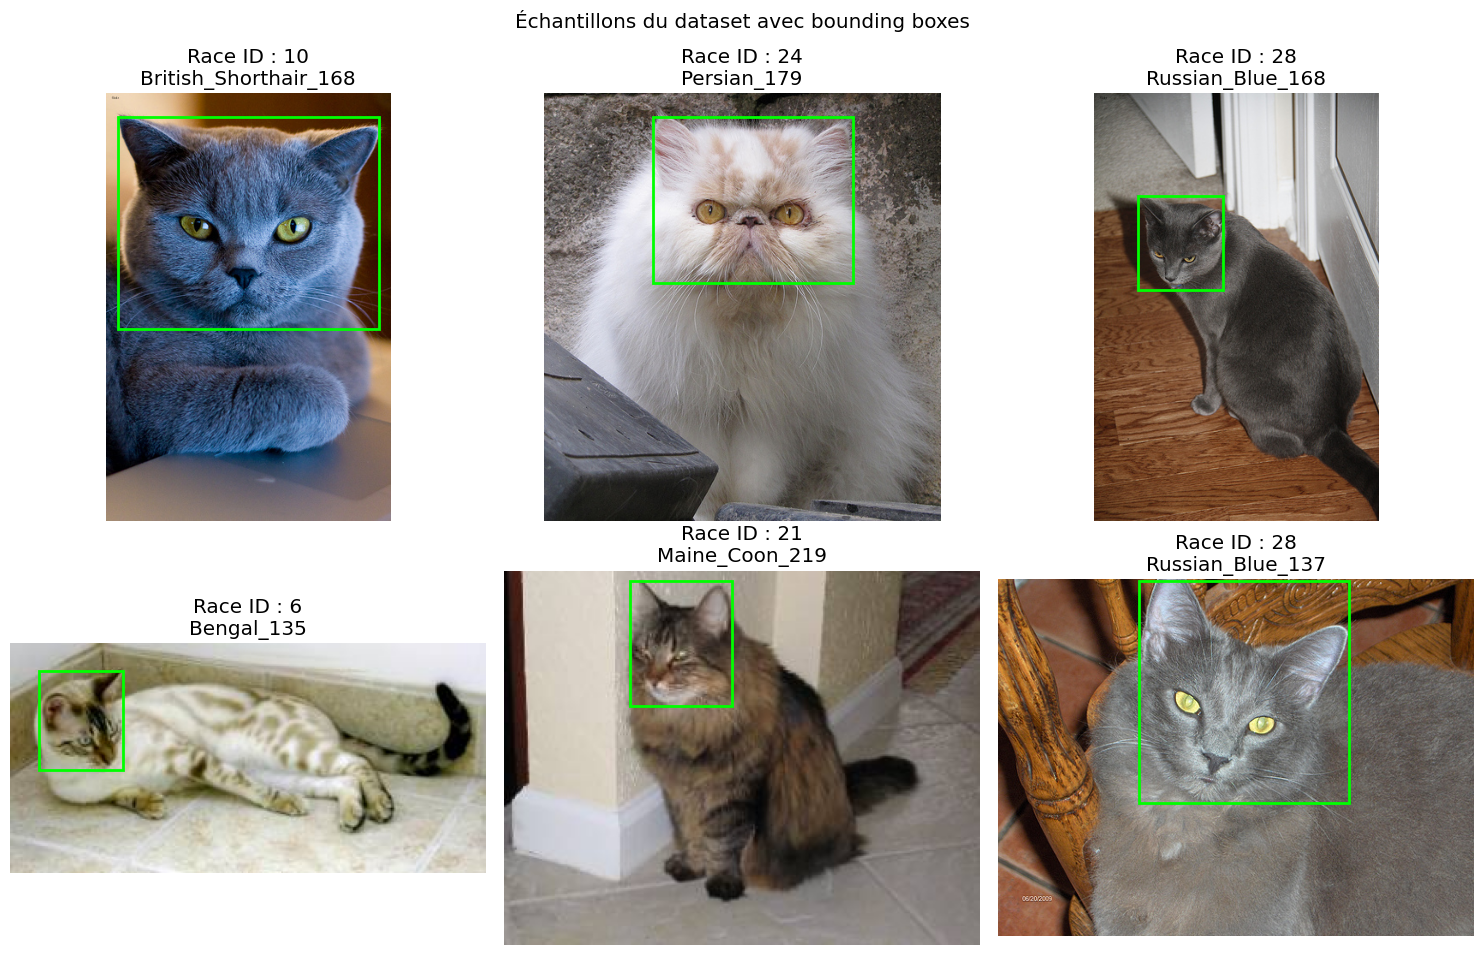

In [ ]:
import cv2

def visualiser_echantillons(df, n_echantillons=6):
    """Affiche un ensemble aléatoire d'images avec les bounding boxes correspondantes."""
    echantillons = df.sample(n=min(n_echantillons, len(df)), random_state=42)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (_, row) in enumerate(echantillons.iterrows()):
        image = cv2.imread(row['chemin_image'])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i].imshow(image_rgb)

        for bbox in row['bboxes']:
            rect = patches.Rectangle(
                (bbox['xmin'], bbox['ymin']),
                bbox['width'],
                bbox['height'],
                linewidth=2,
                edgecolor='lime',
                facecolor='none'
            )
            axes[i].add_patch(rect)

        axes[i].set_title(f"Race ID : {row['class_id']}\n{row['nom_image']}")
        axes[i].axis('off')

    plt.suptitle("Échantillons du dataset avec bounding boxes")
    plt.tight_layout()
    plt.show()

visualiser_echantillons(df_chats_annotes)

### 2.6 Nettoyage du Dataset

Les bounding boxes de très petite taille (moins de 2 % de la surface de l'image) sont filtrées.

In [ ]:
donnees_nettoyees = []
stats_nettoyage = {
    'images_originales': len(df_chats_annotes),
    'bboxes_originales': df_chats_annotes['nb_bboxes'].sum(),
    'bboxes_supprimees': 0,
    'images_supprimees': 0
}

print("Début du nettoyage (seuil : bounding box ≥ 2% de la surface de l'image)")

for _, row in df_chats_annotes.iterrows():
    # Chargement de l'image pour obtenir les vraies dimensions
    img = cv2.imread(row['chemin_image'])
    if img is None:
        stats_nettoyage['images_supprimees'] += 1
        continue
    real_height, real_width = img.shape[:2]
    surface_image = real_width * real_height

    bboxes_valides = []
    for bbox in row['bboxes']:
        surface_bbox = bbox['width'] * bbox['height']
        ratio_surface = surface_bbox / surface_image

        if ratio_surface >= 0.02:
            bboxes_valides.append(bbox)
        else:
            stats_nettoyage['bboxes_supprimees'] += 1

    if bboxes_valides:
        # On garde les vraies dimensions
        donnees_nettoyees.append({
            'nom_image': row['nom_image'],
            'chemin_image': row['chemin_image'],
            'chemin_xml': row['chemin_xml'],
            'class_id': row['class_id'],
            'breed_id': row['breed_id'],
            'width': real_width,
            'height': real_height,
            'bboxes': bboxes_valides,
            'nb_bboxes': len(bboxes_valides)
        })
    else:
        stats_nettoyage['images_supprimees'] += 1

df_chats_final = pd.DataFrame(donnees_nettoyees)

print("\nRésultats du nettoyage")
print(f"Images originales : {stats_nettoyage['images_originales']}")
print(f"Images conservées : {len(df_chats_final)}")
print(f"Images supprimées : {stats_nettoyage['images_supprimees']}")
print(f"Bounding boxes originales : {stats_nettoyage['bboxes_originales']}")
print(f"Bounding boxes conservées : {df_chats_final['nb_bboxes'].sum()}")
print(f"Bounding boxes supprimées : {stats_nettoyage['bboxes_supprimees']}")

Début du nettoyage (seuil : bounding box ≥ 2% de la surface de l'image)

Résultats du nettoyage
Images originales : 1181
Images conservées : 1175
Images supprimées : 6
Bounding boxes originales : 1182
Bounding boxes conservées : 1175
Bounding boxes supprimées : 7


### 2.7 Statistiques Finales et Sauvegarde

Le dataset nettoyé est analysé et sauvegardé avec métadonnées associées.

In [ ]:
# Distribution par nombre de bounding boxes
print("\nDistribution du nombre de bounding boxes par image")
print(df_chats_final['nb_bboxes'].value_counts().sort_index())

# Distribution par race
print("\nDistribution par race")
print(df_chats_final.groupby('class_id').size().sort_values(ascending=False))

# Répertoire de sauvegarde
CHEMIN_SORTIE = Path('dataset_chats_final')
CHEMIN_SORTIE.mkdir(exist_ok=True)

# Sauvegarde CSV et JSON
df_chats_final.to_csv(CHEMIN_SORTIE / 'annotations_chats.csv', index=False)
df_chats_final.to_json(CHEMIN_SORTIE / 'annotations_chats.json', orient='records', indent=2)

# Métadonnées
metadata = {
    'dataset': 'Oxford-IIIT Pet - Chats uniquement',
    'source': 'https://www.robots.ox.ac.uk/~vgg/data/pets/',
    'date_creation': pd.Timestamp.now().isoformat(),
    'nombre_images': len(df_chats_final),
    'nombre_bboxes': int(df_chats_final['nb_bboxes'].sum()),
    'nombre_races': int(df_chats_final['class_id'].nunique()),
    'images_multi_chats': int((df_chats_final['nb_bboxes'] > 1).sum()),
    'nettoyage': {
        'images_supprimees': stats_nettoyage['images_supprimees'],
        'bboxes_supprimees': stats_nettoyage['bboxes_supprimees'],
        'seuil_surface': '2%'
    }
}

with open(CHEMIN_SORTIE / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"\nDataset final sauvegardé dans {CHEMIN_SORTIE}")


Distribution du nombre de bounding boxes par image
nb_bboxes
1    1175
Name: count, dtype: int64

Distribution par race
class_id
34    100
24    100
21    100
10    100
28     99
27     99
33     99
1      99
7      98
8      96
6      95
12     90
dtype: int64

Dataset final sauvegardé dans dataset_chats_final


## 3. Augmentation du Dataset avec Exemples Négatifs

Cette section enrichit le dataset en ajoutant des exemples négatifs (images sans chat) issus de chiens du même dataset et d'images d'humains provenant de COCO. L'objectif consiste à améliorer la discrimination du modèle en évitant les faux positifs sur des objets similaires.

### 3.1 Extraction d'Exemples Négatifs : Chiens

Un sous-ensemble aléatoire d'images de chiens est sélectionné comme exemples négatifs (sans bounding box).


In [ ]:
random.seed(42)

# Filtrage des chiens
df_chiens = df_complet[~df_complet['est_chat']].copy()
df_chiens.reset_index(drop=True, inplace=True)

print(f"Nombre total d'images de chiens disponibles : {len(df_chiens)}")

# Échantillonnage (maximum 1000 images)
n_chiens_negatifs = min(1000, len(df_chiens))
df_chiens_sample = df_chiens.sample(n=n_chiens_negatifs, random_state=42)

# Création des entrées négatives
donnees_chiens_negatifs = []
for _, row in df_chiens_sample.iterrows():
    nom_base = row['nom_image']
    chemin_image = CHEMIN_IMAGES / f"{nom_base}.jpg"
    if chemin_image.exists():
        img = cv2.imread(str(chemin_image))
        if img is not None:
            height, width, _ = img.shape
            donnees_chiens_negatifs.append({
                'nom_image': nom_base,
                'chemin_image': str(chemin_image),
                'chemin_xml': '',
                'class_id': 0,
                'breed_id': 0,
                'width': width,
                'height': height,
                'bboxes': [],
                'nb_bboxes': 0,
                'is_negative': True
            })

df_chiens_negatifs = pd.DataFrame(donnees_chiens_negatifs)
print(f"Exemples négatifs (chiens) créés : {len(df_chiens_negatifs)} images")

Nombre total d'images de chiens disponibles : 4978
Exemples négatifs (chiens) créés : 1000 images


Corrupt JPEG data: premature end of data segment


### 3.2 Extraction d'Exemples Négatifs : Humains (sous-ensemble COCO)

Un ensemble d'images contenant des personnes est téléchargé depuis le dataset COCO 2017 (validation) pour constituer des exemples négatifs supplémentaires.


In [ ]:
# Installation de pycocotools
!conda install -y -q pycocotools -c conda-forge

Retrieving notices: ...working... done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pycocotools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2026.1.4   |       hbd8a1cb_0         143 KB  conda-forge
    certifi-2026.1.4           |     pyhd8ed1ab_0         147 KB  conda-forge
    conda-25.11.1              |  py312h7900ff3_0         1.2 MB  conda-forge
    pycocotools-2.0.11         |  py312h4f23490_0         107 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.5 MB

The following NEW packages will be INSTALLED:

  pycocotools        conda-forge/linux-64::pycocotools-2.0.11-py312h4f23490_0 

The following packages will be UPDATED:

  ca-certificates   

In [ ]:
from pycocotools.coco import COCO
import urllib.request

CHEMIN_HUMAINS = Path('images_humains')
CHEMIN_HUMAINS.mkdir(exist_ok=True)

# Téléchargement des annotations COCO
coco_ann_file = 'annotations_trainval2017.zip'
coco_ann_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
json_path = Path('annotations/instances_val2017.json')

if not json_path.exists():
    print("Téléchargement des annotations COCO 2017")
    os.system(f"wget -q {coco_ann_url} -O {coco_ann_file}")
    os.system(f"unzip -q {coco_ann_file}")
    print("Annotations COCO extraites")

# Chargement des annotations
coco = COCO(json_path)

# Identification des images contenant des personnes
person_cat_id = coco.getCatIds(catNms=['person'])[0]
person_img_ids = coco.getImgIds(catIds=[person_cat_id])

# Sélection de 300 images
n_humains = 300
person_img_ids_sample = random.sample(person_img_ids, min(n_humains, len(person_img_ids)))

donnees_humains_negatifs = []
print(f"Téléchargement de {len(person_img_ids_sample)} images contenant des humains")

for img_id in person_img_ids_sample:
    img_info = coco.loadImgs(img_id)[0]
    img_url = img_info['coco_url']
    img_filename = f"person_{img_id}.jpg"
    img_path = CHEMIN_HUMAINS / img_filename

    if not img_path.exists():
        try:
            urllib.request.urlretrieve(img_url, img_path)
        except:
            continue

    if img_path.exists():
        img = cv2.imread(str(img_path))
        if img is not None:
            height, width, _ = img.shape
            donnees_humains_negatifs.append({
                'nom_image': img_filename.replace('.jpg', ''),
                'chemin_image': str(img_path),
                'chemin_xml': '',
                'class_id': 0,
                'breed_id': 0,
                'width': width,
                'height': height,
                'bboxes': [],
                'nb_bboxes': 0,
                'is_negative': True
            })

df_humains_negatifs = pd.DataFrame(donnees_humains_negatifs)
print(f"Exemples négatifs (humains) créés : {len(df_humains_negatifs)} images")

Téléchargement des annotations COCO 2017
Annotations COCO extraites
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Téléchargement de 300 images contenant des humains
Exemples négatifs (humains) créés : 300 images


### 3.3 Combinaison des Datasets

Les exemples positifs (chats) et négatifs (chiens + humains) sont combinés et mélangés.


In [ ]:
# Ajout du flag pour les exemples positifs
df_chats_final['is_negative'] = False

# Concaténation
df_dataset_augmente = pd.concat([
    df_chats_final,
    df_chiens_negatifs,
    df_humains_negatifs
], ignore_index=True)

# Mélange aléatoire pour éviter les biais d'ordre
df_dataset_augmente = df_dataset_augmente.sample(frac=1, random_state=42).reset_index(drop=True)

# Statistiques du dataset augmenté
n_positifs = len(df_chats_final)
n_negatifs = len(df_chiens_negatifs) + len(df_humains_negatifs)
n_total = len(df_dataset_augmente)

print("Composition du dataset augmenté")
print(f"Images positives (chats) : {n_positifs}")
print(f"Images négatives (chiens + humains) : {n_negatifs}")
print(f"Total : {n_total}")
print(f"Pourcentage d'images positives : {n_positifs / n_total * 100:.1f}%")

Composition du dataset augmenté
Images positives (chats) : 1175
Images négatives (chiens + humains) : 1300
Total : 2475
Pourcentage d'images positives : 47.5%


### 3.4 Sauvegarde du Dataset Augmenté

Le dataset final enrichi est sauvegardé pour les étapes suivantes.

In [ ]:
CHEMIN_DATASET_AUGMENTE = Path('dataset_avec_negatifs')
CHEMIN_DATASET_AUGMENTE.mkdir(exist_ok=True)

# Sauvegarde au format CSV et JSON
df_dataset_augmente.to_csv(CHEMIN_DATASET_AUGMENTE / 'dataset_complet.csv', index=False)
df_dataset_augmente.to_json(CHEMIN_DATASET_AUGMENTE / 'dataset_complet.json', orient='records', indent=2)

print(f"Dataset augmenté sauvegardé dans {CHEMIN_DATASET_AUGMENTE}")

Dataset augmenté sauvegardé dans dataset_avec_negatifs


## 4. Division du Dataset et Préparation des Chargements de Données

Cette section divise le dataset augmenté en ensembles d'entraînement, de validation et de test. Une classe personnalisée PyTorch Dataset est définie pour gérer les exemples positifs et négatifs, suivie de la création des DataLoaders.

### 4.1 Division Stratifiée du Dataset

La division respecte la proportion d'exemples positifs et négatifs grâce à une stratification.


In [ ]:
from sklearn.model_selection import train_test_split

# Colonne de stratification basée sur la présence d'un chat
df_dataset_augmente['stratify_class'] = df_dataset_augmente['is_negative'].astype(int)

# Split initial : 70% train, 30% temporaire
train_df, temp_df = train_test_split(
    df_dataset_augmente,
    test_size=0.3,
    random_state=42,
    stratify=df_dataset_augmente['stratify_class']
)

# Split du temporaire : 15% validation, 15% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['stratify_class']
)

# Réindexation
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Statistiques des splits
print("Répartition des ensembles")
print(f"Train   : {len(train_df)} images ({(~train_df['is_negative']).sum()} positifs, {train_df['is_negative'].sum()} négatifs)")
print(f"Validation : {len(val_df)} images ({(~val_df['is_negative']).sum()} positifs, {val_df['is_negative'].sum()} négatifs)")
print(f"Test    : {len(test_df)} images ({(~test_df['is_negative']).sum()} positifs, {test_df['is_negative'].sum()} négatifs)")

# Sauvegarde des splits
CHEMIN_SPLITS = CHEMIN_DATASET_AUGMENTE / 'splits'
CHEMIN_SPLITS.mkdir(exist_ok=True)
train_df.to_csv(CHEMIN_SPLITS / 'train.csv', index=False)
val_df.to_csv(CHEMIN_SPLITS / 'val.csv', index=False)
test_df.to_csv(CHEMIN_SPLITS / 'test.csv', index=False)
print(f"Splits sauvegardés dans {CHEMIN_SPLITS}")

Répartition des ensembles
Train   : 1732 images (822 positifs, 910 négatifs)
Validation : 371 images (176 positifs, 195 négatifs)
Test    : 372 images (177 positifs, 195 négatifs)
Splits sauvegardés dans dataset_avec_negatifs/splits


### 4.2 Définition des Transformations

Les transformations d'augmentation et de prétraitement sont définies séparément pour l'entraînement et l'évaluation.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    """Transformations appliquées pendant l'entraînement."""
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.Resize(height=512, width=512),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_val_transforms():
    """Transformations appliquées pendant la validation et le test."""
    return A.Compose([
        A.Resize(height=512, width=512),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

### 4.3 Classe Dataset PyTorch Personnalisée

Une classe Dataset est implémentée pour charger les images et gérer les exemples négatifs (sans bounding boxes).


In [ ]:
import ast

class CatDetectionDataset(Dataset):
    """Dataset compatible avec Faster R-CNN, supportant les exemples négatifs."""
    def __init__(self, dataframe, transforms=None):
        self.df = dataframe.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]

        # Chargement de l'image
        image = cv2.imread(row['chemin_image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Gestion des bounding boxes
        if row['is_negative'] or row['nb_bboxes'] == 0:
            boxes = []
            labels = []
        else:
            # Parsing si nécessaire (au cas où les bboxes sont stockées en string)
            bboxes = row['bboxes']
            if isinstance(bboxes, str):
                bboxes = ast.literal_eval(bboxes)
            boxes = [[float(b['xmin']), float(b['ymin']), float(b['xmax']), float(b['ymax'])] for b in bboxes]
            labels = [1] * len(boxes)  # Classe 1 = chat

        # Application des transformations
        if self.transforms:
            if len(boxes) > 0:
                transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
                image = transformed['image']
                boxes = transformed['bboxes']
            else:
                # Transformation simplifiée pour les exemples négatifs
                simple_transform = A.Compose([
                    A.Resize(height=512, width=512),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
                image = simple_transform(image=image)['image']
                boxes = []

        # Format cible requis par Faster R-CNN
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }

        return image, target

### 4.4 Création des DataLoaders

Les DataLoaders sont configurés avec une fonction collate adaptée à la détection d'objets.

In [ ]:
BATCH_SIZE = 8
NUM_WORKERS = 6
PIN_MEMORY = torch.cuda.is_available()
PREFETCH_FACTOR = 2
PERSISTENT_WORKERS = True

def collate_fn(batch):
    """Fonction de collation pour les batchs de taille variable (détection d'objets)."""
    return tuple(zip(*batch))

# Datasets
train_dataset = CatDetectionDataset(train_df, transforms=get_train_transforms())
val_dataset   = CatDetectionDataset(val_df,   transforms=get_val_transforms())
test_dataset  = CatDetectionDataset(test_df,  transforms=get_val_transforms())

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=PERSISTENT_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=PERSISTENT_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=PERSISTENT_WORKERS
)

print("DataLoaders")
print(f"Configuration : batch_size={BATCH_SIZE}, num_workers={NUM_WORKERS}")
print(f"Nombre de batchs → Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

DataLoaders
Configuration : batch_size=8, num_workers=6
Nombre de batchs → Train: 217, Val: 47, Test: 47


### 4.5 Vérification du Chargement et de la Distribution

Un test de chargement est effectué et la distribution des exemples positifs dans les batchs d'entraînement est analysée.


In [ ]:
# Test de chargement d'un batch
images, targets = next(iter(train_loader))
print(f"Batch de test chargé : {len(images)} images")

positifs = sum(1 for t in targets if len(t['boxes']) > 0)
print(f"Dans ce batch : {positifs} images positives, {len(images) - positifs} négatives")

# Analyse rapide de la distribution sur 50 batchs
n_batches_check = 50
positives_per_batch = []

for i, (_, batch_targets) in enumerate(train_loader):
    if i >= n_batches_check:
        break
    positives = sum(1 for t in batch_targets if len(t['boxes']) > 0)
    positives_per_batch.append(positives)

positives_per_batch = np.array(positives_per_batch)
print("\nAnalyse de la distribution sur 50 batchs d'entraînement")
print(f"Moyenne d'images positives par batch : {positives_per_batch.mean():.2f}")
print(f"Écart-type : {positives_per_batch.std():.2f}")
print(f"Minimum : {positives_per_batch.min()}, Maximum : {positives_per_batch.max()}")
print(f"Pourcentage de batchs sans positif : {np.mean(positives_per_batch == 0) * 100:.1f}%")

Batch de test chargé : 8 images
Dans ce batch : 5 images positives, 3 négatives


Corrupt JPEG data: premature end of data segment



Analyse de la distribution sur 50 batchs d'entraînement
Moyenne d'images positives par batch : 3.86
Écart-type : 1.43
Minimum : 1, Maximum : 7
Pourcentage de batchs sans positif : 0.0%


### 4.6 Visualisation d'un Batch d'Entraînement

Un batch du DataLoader d'entraînement est chargé et quatre images sont affichées avec leurs bounding boxes (ground truth).

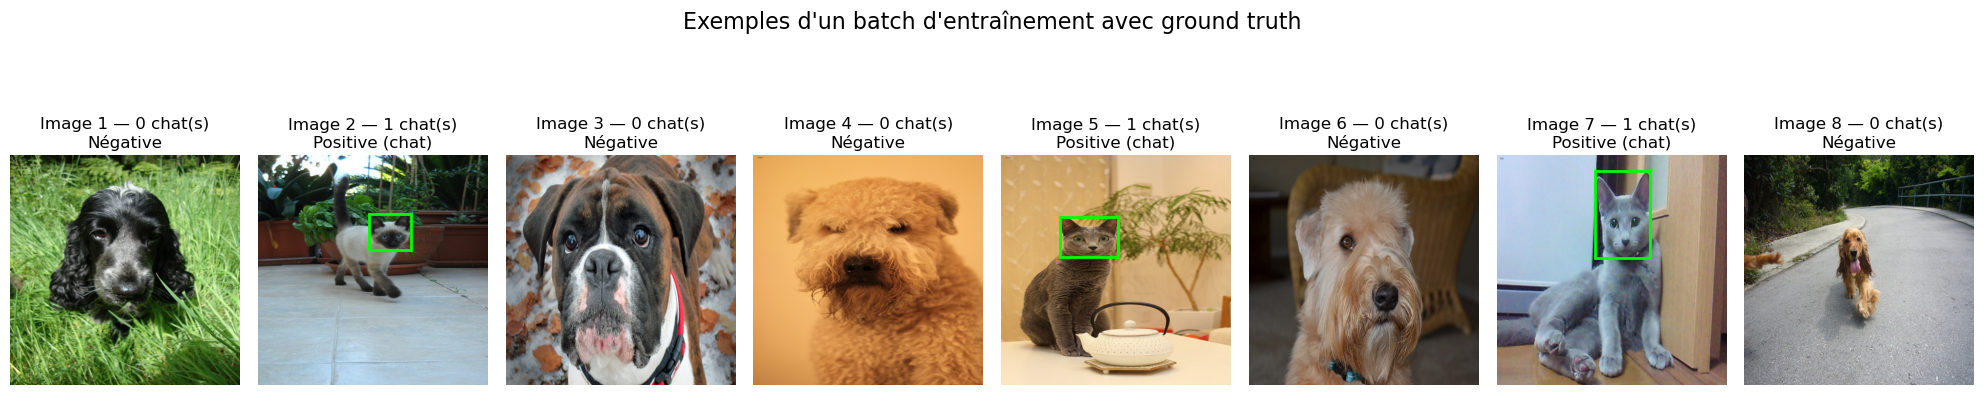

8 images visualisées parmi un batch de 8.
Dans ce batch : 3 images positives, 5 images négatives.


In [ ]:
# Chargement d'un batch d'entraînement
images, targets = next(iter(train_loader))

# Sélection de 8 images
n_visualiser = min(8, len(images))

fig, axes = plt.subplots(1, n_visualiser, figsize=(20, 5))
if n_visualiser == 1:
    axes = [axes]

for i in range(n_visualiser):
    ax = axes[i]

    # Récupération de l'image (tenseur normalisé)
    img = images[i].cpu()

    # Dénormalisation pour affichage
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    ax.imshow(img_np)

    # Affichage des bounding boxes (ground truth)
    boxes = targets[i]['boxes'].cpu().numpy()
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin), width, height,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)

    # Titre indiquant le nombre de chats dans l'image
    n_boxes = len(boxes)
    type_img = "Positive (chat)" if n_boxes > 0 else "Négative"
    ax.set_title(f"Image {i+1} — {n_boxes} chat(s)\n{type_img}", fontsize=12)
    ax.axis('off')

plt.suptitle("Exemples d'un batch d'entraînement avec ground truth", fontsize=16)
plt.tight_layout()
plt.show()

print(f"{n_visualiser} images visualisées parmi un batch de {len(images)}.")
print(f"Dans ce batch : {sum(len(t['boxes']) > 0 for t in targets)} images positives, "
      f"{len(images) - sum(len(t['boxes']) > 0 for t in targets)} images négatives.")

## 5. Définition et Entraînement du Modèle Faster R-CNN

Cette section charge un modèle Faster R-CNN pré-entraîné, l'adapte à la tâche binaire (background + chat), configure l'optimiseur et le scheduler, puis exécute l'entraînement avec suivi des pertes.

### 5.1 Chargement et Adaptation du Modèle


Un modèle Faster R-CNN avec backbone ResNet-50-FPN (version 2) pré-entraîné sur COCO est utilisé. La tête de classification est remplacée pour gérer 2 classes.

In [ ]:
# Chargement du modèle pré-entraîné
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights)

# Adaptation de la tête pour 2 classes (0: background, 1: chat) => transfer learning
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

# Transfert sur le dispositif cible
model.to(device)

print("Modèle Faster R-CNN chargé et adapté (2 classes)")
print(f"Dispositif : {device}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 237MB/s] 


Modèle Faster R-CNN chargé et adapté (2 classes)
Dispositif : cuda:0


### 5.2 Configuration de l'Optimiseur et du Scheduler

Un optimiseur SGD avec momentum et un scheduler StepLR sont définis.


In [ ]:
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

# Hyperparamètres optimisés pour Faster R-CNN avec transfer learning
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_EPOCHS = 20
STEP_SIZE = 8
GAMMA = 0.1

# Optimiseur SGD (standard pour Faster R-CNN dans la littérature)
optimizer = SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

# Scheduler : réduction du LR tous les STEP_SIZE epochs
lr_scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

print(f"Optimiseur SGD configuré (LR={LEARNING_RATE}, momentum={MOMENTUM}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler StepLR : réduction du LR x{GAMMA} tous les {STEP_SIZE} epochs")
print(f"Nombre d'epochs prévu : {NUM_EPOCHS}")

Optimiseur SGD configuré (LR=0.005, momentum=0.9, weight_decay=0.0005)
Scheduler StepLR : réduction du LR x0.1 tous les 8 epochs
Nombre d'epochs prévu : 20


In [ ]:
# Visualisation de l'architecture du modèle

!pip install torchinfo

from torchinfo import summary

# Summary avec une image fictive (batch_size=1, 3 channels, 512x512)
summary(model, input_size=(1, 3, 512, 512), device=device)

Layer (type:depth-idx)                             Output Shape              Param #
FasterRCNN                                         [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                    [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                             [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                            [1, 64, 400, 400]         (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 400, 400]         (128)
│    │    └─ReLU: 3-3                              [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                        [1, 256, 200, 200]        (215,808)
│    │    └─Sequential: 3-6                        [1, 512, 100, 100]        1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 50, 50]         7,098,368
│    │

Le modèle Faster R-CNN ResNet50-FPN v2 est chargé avec des poids pré-entraînés sur COCO (transfer learning). La tête de prédiction est adaptée pour 2 classes (background + chat). Toutes les couches restent entraînables (fine-tuning complet), permettant au modèle d’ajuster finement les features extraites aux spécificités du dataset chats. Seuls ~225k paramètres (statistiques BatchNorm) sont non-entraînables, ce qui est standard et optimal pour cette taille de dataset.

### 5.3 Boucle d'Entraînement et de Validation

Le modèle est entraîné avec calcul de la perte totale. La validation utilise le même mode (les pertes de détection sont calculées en mode train).

In [ ]:
from tqdm.auto import tqdm
import time
import json

history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []
}

best_val_loss = float('inf')
best_epoch = 0

# Dossier de sauvegarde des modèles
CHEMIN_MODELES = Path('modeles_detection_chats')
CHEMIN_MODELES.mkdir(exist_ok=True)

print("Démarrage de l'entraînement")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # Phase d'entraînement
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, targets in train_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        train_bar.set_postfix({
            'loss': f'{losses.item():.4f}',
            'avg': f'{train_loss / (train_bar.n + 1):.4f}'
        })

    train_loss /= len(train_loader)

    # Phase de validation : on force model.train() pour calculer les pertes
    model.train()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
    with torch.no_grad():
        for images, targets in val_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_loss += losses.item()
            val_bar.set_postfix({
                'val_loss': f'{losses.item():.4f}',
                'avg': f'{val_loss / (val_bar.n + 1):.4f}'
            })

    val_loss /= len(val_loader)
    model.eval()  # Retour en mode eval après validation

    # Scheduler et historique
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} terminé en {epoch_time:.1f}s")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    # Sauvegarde du meilleur modèle basé sur val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'history': history
        }
        torch.save(checkpoint, CHEMIN_MODELES / 'best_model.pth')
        print(f"Meilleur modèle sauvegardé (Val Loss: {val_loss:.4f})")

# Fin de l'entraînement
total_time = time.time() - start_time
print(f"\nEntraînement terminé en {total_time/60:.1f} minutes")
print(f"Meilleur epoch : {best_epoch} (Val Loss: {best_val_loss:.4f})")

# Sauvegarde finale
torch.save(model.state_dict(), CHEMIN_MODELES / 'final_model.pth')
with open(CHEMIN_MODELES / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

Démarrage de l'entraînement


Epoch 1/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 1/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 1/20 terminé en 480.9s
Train Loss: 0.0450 | Val Loss: 0.0195 | LR: 0.005000
Meilleur modèle sauvegardé (Val Loss: 0.0195)


Epoch 2/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 2/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 2/20 terminé en 483.2s
Train Loss: 0.0451 | Val Loss: 0.0169 | LR: 0.005000
Meilleur modèle sauvegardé (Val Loss: 0.0169)


Epoch 3/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 3/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 3/20 terminé en 483.1s
Train Loss: 0.0391 | Val Loss: 0.0158 | LR: 0.005000
Meilleur modèle sauvegardé (Val Loss: 0.0158)


Epoch 4/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 4/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 4/20 terminé en 483.2s
Train Loss: 0.0427 | Val Loss: 0.0147 | LR: 0.005000
Meilleur modèle sauvegardé (Val Loss: 0.0147)


Epoch 5/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 5/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 5/20 terminé en 483.5s
Train Loss: 0.0377 | Val Loss: 0.0142 | LR: 0.005000
Meilleur modèle sauvegardé (Val Loss: 0.0142)


Epoch 6/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 6/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 6/20 terminé en 483.0s
Train Loss: 0.0384 | Val Loss: 0.0132 | LR: 0.005000
Meilleur modèle sauvegardé (Val Loss: 0.0132)


Epoch 7/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 7/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 7/20 terminé en 482.9s
Train Loss: 0.0378 | Val Loss: 0.0134 | LR: 0.005000


Epoch 8/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 8/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 8/20 terminé en 482.9s
Train Loss: 0.0354 | Val Loss: 0.0138 | LR: 0.000500


Epoch 9/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 9/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 9/20 terminé en 483.0s
Train Loss: 0.0334 | Val Loss: 0.0128 | LR: 0.000500
Meilleur modèle sauvegardé (Val Loss: 0.0128)


Epoch 10/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 10/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 10/20 terminé en 483.0s
Train Loss: 0.0341 | Val Loss: 0.0126 | LR: 0.000500
Meilleur modèle sauvegardé (Val Loss: 0.0126)


Epoch 11/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Epoch 11/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 11/20 terminé en 483.0s
Train Loss: 0.0347 | Val Loss: 0.0122 | LR: 0.000500
Meilleur modèle sauvegardé (Val Loss: 0.0122)


Epoch 12/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 12/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 12/20 terminé en 483.4s
Train Loss: 0.0341 | Val Loss: 0.0124 | LR: 0.000500


Epoch 13/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 13/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 13/20 terminé en 483.1s
Train Loss: 0.0356 | Val Loss: 0.0121 | LR: 0.000500
Meilleur modèle sauvegardé (Val Loss: 0.0121)


Epoch 14/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 14/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 14/20 terminé en 483.4s
Train Loss: 0.0336 | Val Loss: 0.0120 | LR: 0.000500
Meilleur modèle sauvegardé (Val Loss: 0.0120)


Epoch 15/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 15/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 15/20 terminé en 482.9s
Train Loss: 0.0317 | Val Loss: 0.0118 | LR: 0.000500
Meilleur modèle sauvegardé (Val Loss: 0.0118)


Epoch 16/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 16/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 16/20 terminé en 483.0s
Train Loss: 0.0331 | Val Loss: 0.0118 | LR: 0.000050
Meilleur modèle sauvegardé (Val Loss: 0.0118)


Epoch 17/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 17/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 17/20 terminé en 483.3s
Train Loss: 0.0327 | Val Loss: 0.0116 | LR: 0.000050
Meilleur modèle sauvegardé (Val Loss: 0.0116)


Epoch 18/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 18/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 18/20 terminé en 483.1s
Train Loss: 0.0319 | Val Loss: 0.0118 | LR: 0.000050


Epoch 19/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 19/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 19/20 terminé en 483.4s
Train Loss: 0.0339 | Val Loss: 0.0120 | LR: 0.000050


Epoch 20/20 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment


Epoch 20/20 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]


Epoch 20/20 terminé en 482.8s
Train Loss: 0.0326 | Val Loss: 0.0118 | LR: 0.000050

Entraînement terminé en 161.5 minutes
Meilleur epoch : 17 (Val Loss: 0.0116)


### 5.4 Visualisation des Courbes d'Apprentissage

Les pertes d'entraînement/validation et l'évolution du learning rate sont tracées.


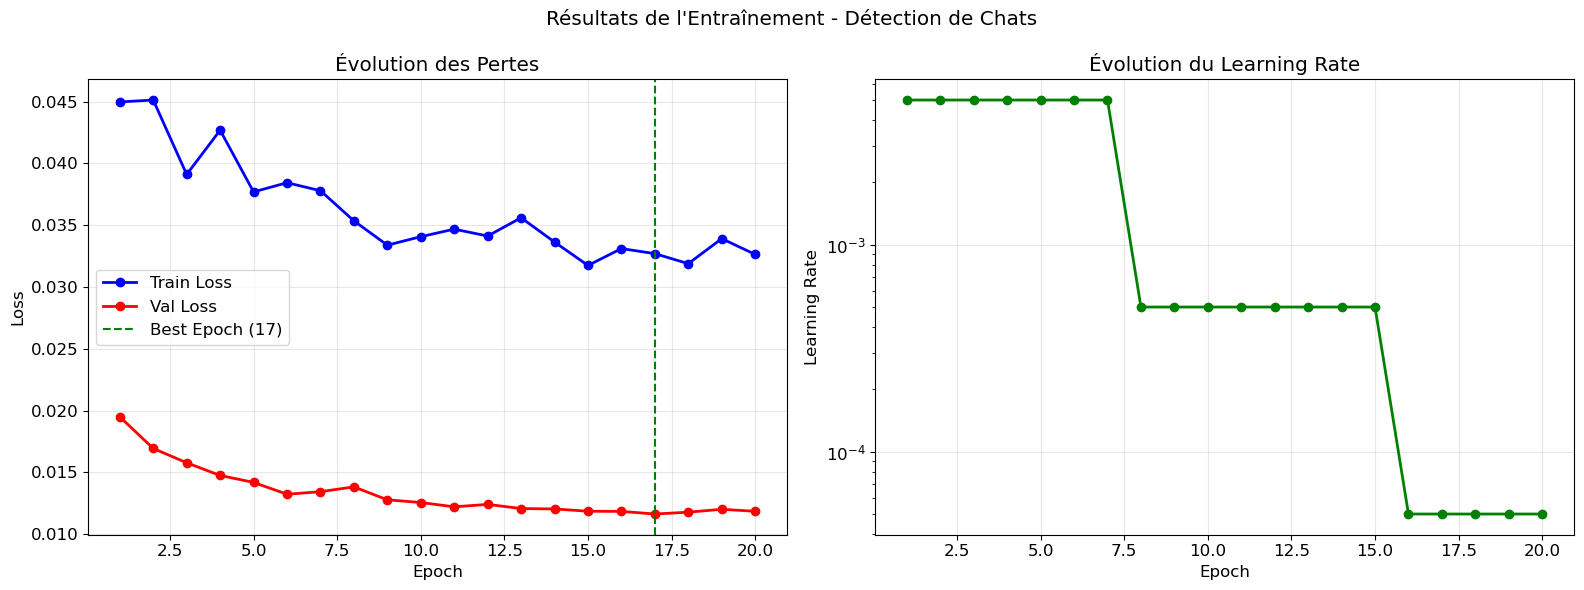

In [ ]:
epochs_range = range(1, NUM_EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Courbes de perte
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
ax1.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Évolution des Pertes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Learning rate
ax2.plot(epochs_range, history['lr'], 'g-o', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Évolution du Learning Rate')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.suptitle('Résultats de l\'Entraînement - Détection de Chats')
plt.tight_layout()
plt.savefig(CHEMIN_MODELES / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Evaluation du modèle sur le test set

Modèle chargé depuis : modeles_detection_chats/best_model.pth
Epoch du checkpoint : 17
Validation loss : 0.0116

------------------------------------------------------------
évaluation avec différents seuils de confiance
------------------------------------------------------------

seuil de confiance : 0.3
  précision : 0.9305 (93.0%)
  rappel    : 0.9831 (98.3%)
  f1-score  : 0.9560
  iou moyen : 0.8746
  vrais +   : 174
  faux +    : 13
  faux -    : 3

seuil de confiance : 0.5
  précision : 0.9611 (96.1%)
  rappel    : 0.9774 (97.7%)
  f1-score  : 0.9692
  iou moyen : 0.9036
  vrais +   : 173
  faux +    : 7
  faux -    : 4

seuil de confiance : 0.7
  précision : 0.9774 (97.7%)
  rappel    : 0.9774 (97.7%)
  f1-score  : 0.9774
  iou moyen : 0.9176
  vrais +   : 173
  faux +    : 4
  faux -    : 4

seuil de confiance : 0.8
  précision : 0.9830 (98.3%)
  rappel    : 0.9774 (97.7%)
  f1-score  : 0.9802
  iou moyen : 0.9228
  vrais +   : 173
  faux +    : 3
  faux -    : 4

------------

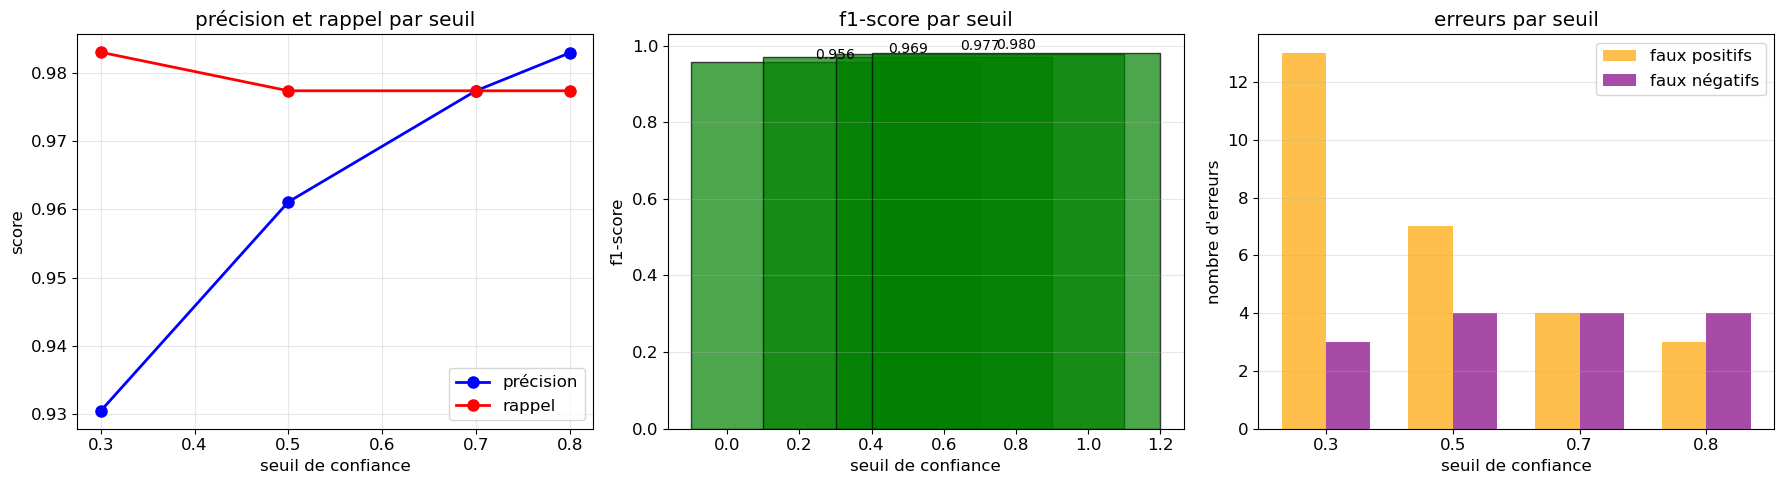


graphique sauvegardé : modeles_detection_chats/resultats_seuils.png

------------------------------------------------------------
visualisation des prédictions
------------------------------------------------------------

génération des visualisations...
visualisations sauvegardées : modeles_detection_chats/predictions_test.png


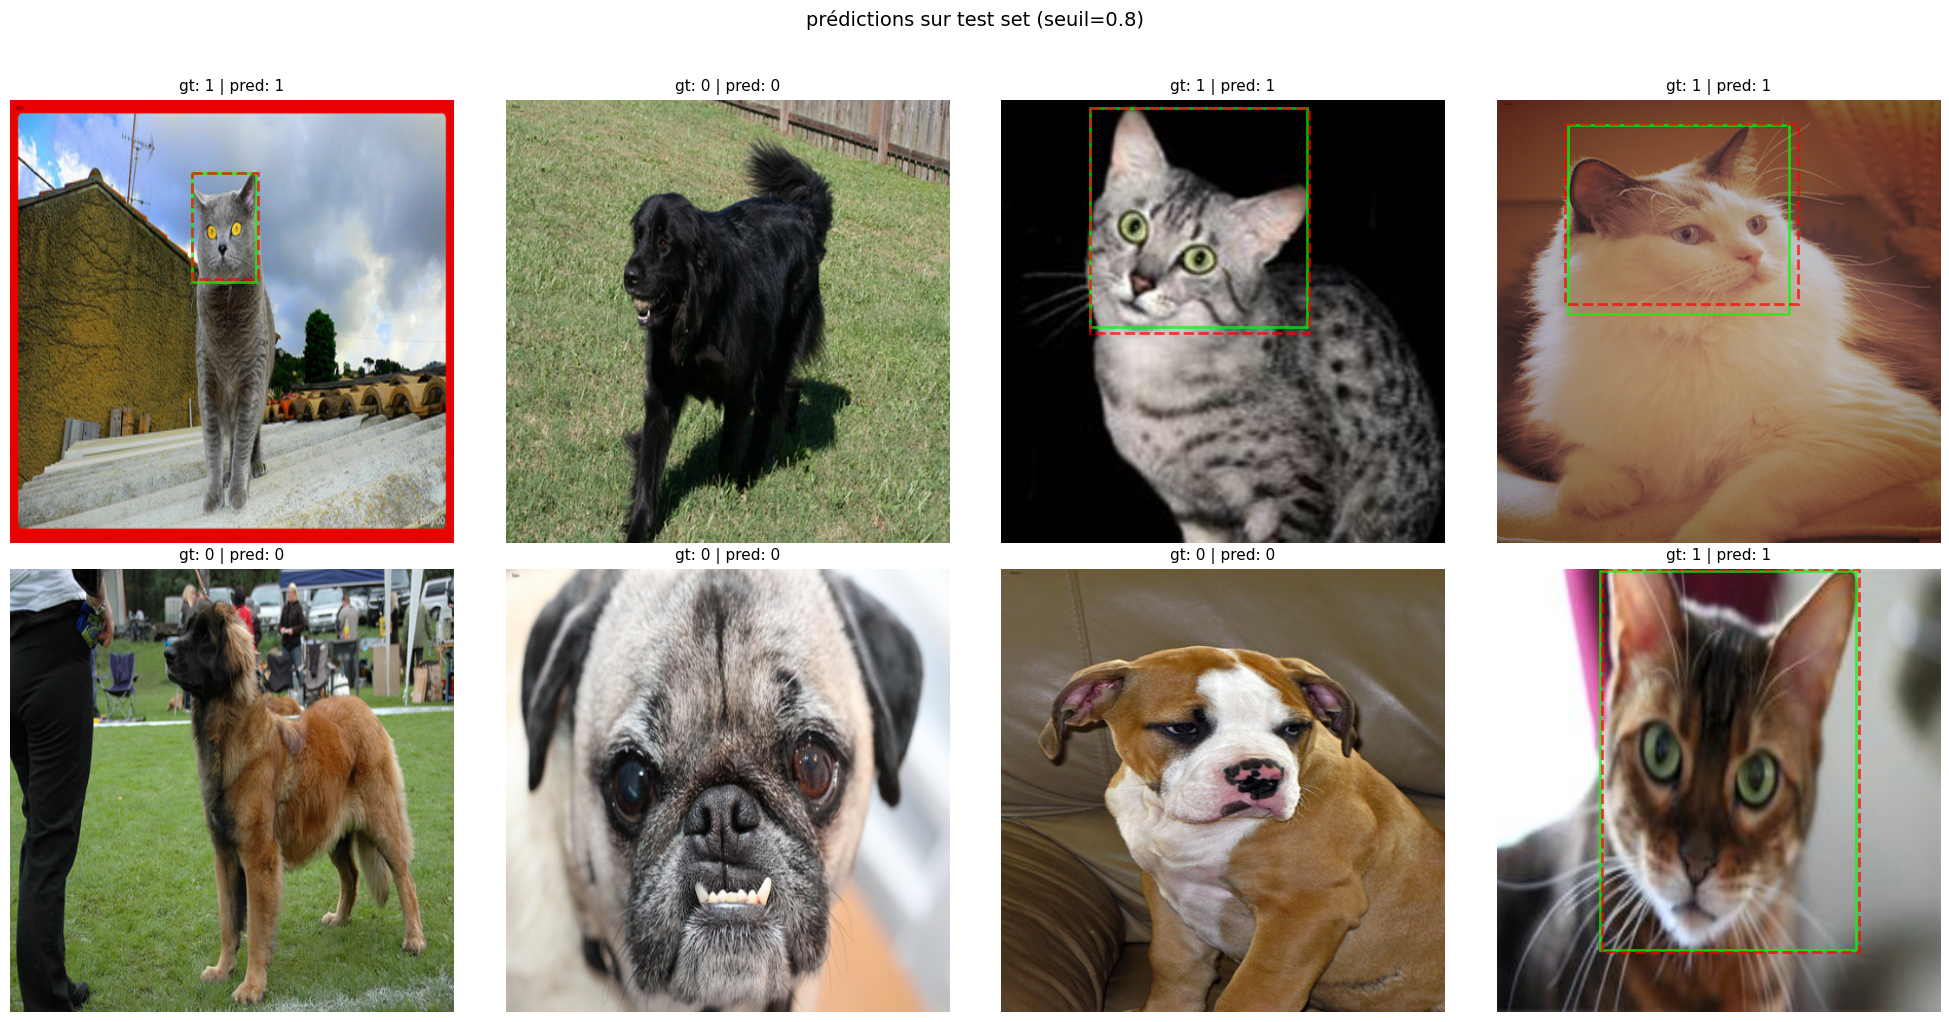


résultats d'évaluation sauvegardés : modeles_detection_chats/resultats_evaluation.json


In [ ]:
# ------------------------------------------------------------
# Chargement du meilleur modèle
# ------------------------------------------------------------

def charger_modele_optimal(chemin_modele, num_classes=2):
    """
    Charge le modèle Faster R-CNN V2
    """
    from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

    weights = None  # On ne charge pas les poids pré-entraînés ici, on va charger notre checkpoint
    modele = fasterrcnn_resnet50_fpn_v2(weights=weights)

    # Adaptation de la tête pour 2 classes (background + chat)
    in_features = modele.roi_heads.box_predictor.cls_score.in_features
    modele.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Chargement du checkpoint
    checkpoint = torch.load(chemin_modele, map_location=device)

    # Chargement des poids
    if 'model_state_dict' in checkpoint:
        modele.load_state_dict(checkpoint['model_state_dict'])
    else:
        modele.load_state_dict(checkpoint)  # cas du final_model.pth qui contient juste le state_dict

    modele.to(device)
    modele.eval()

    print(f"Modèle chargé depuis : {chemin_modele}")
    if 'epoch' in checkpoint:
        print(f"Epoch du checkpoint : {checkpoint['epoch']}")
    if 'val_loss' in checkpoint:
        print(f"Validation loss : {checkpoint['val_loss']:.4f}")

    return modele, checkpoint

# chemin vers le meilleur modèle
chemin_meilleur_modele = CHEMIN_MODELES / 'best_model.pth'
if not chemin_meilleur_modele.exists():
    chemin_meilleur_modele = CHEMIN_MODELES / 'final_model.pth'

modele_eval, checkpoint = charger_modele_optimal(chemin_meilleur_modele)

# ------------------------------------------------------------
# Fonctions de calcul des métriques
# ------------------------------------------------------------

def calculer_iou(boite1, boite2):
    """
    calcule l'intersection sur union entre deux bounding boxes
    format : [xmin, ymin, xmax, ymax]
    """
    # coordonnées de l'intersection
    x1 = max(boite1[0], boite2[0])
    y1 = max(boite1[1], boite2[1])
    x2 = min(boite1[2], boite2[2])
    y2 = min(boite1[3], boite2[3])

    # aire de l'intersection
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # aires des boîtes individuelles
    aire1 = (boite1[2] - boite1[0]) * (boite1[3] - boite1[1])
    aire2 = (boite2[2] - boite2[0]) * (boite2[3] - boite2[1])

    # union
    union = aire1 + aire2 - intersection

    # iou
    return intersection / union if union > 0 else 0

def evaluer_predictions(predictions, targets, seuil_iou=0.5):
    """
    évalue les prédictions par rapport aux ground truth
    retourne les métriques de précision, rappel et f1-score
    """
    vrais_positifs = 0
    faux_positifs = 0
    faux_negatifs = 0
    tous_ious = []

    for pred, target in zip(predictions, targets):
        boites_pred = pred['boxes'].cpu().numpy()
        scores_pred = pred['scores'].cpu().numpy()
        boites_target = target['boxes'].cpu().numpy()

        # mise en correspondance par score décroissant
        indices_pred_tries = np.argsort(-scores_pred)
        boites_pred = boites_pred[indices_pred_tries]

        boites_target_matchées = set()

        # pour chaque prédiction
        for boite_pred in boites_pred:
            meilleur_iou = 0
            meilleur_idx = -1

            # recherche de la meilleure correspondance
            for idx, boite_target in enumerate(boites_target):
                if idx in boites_target_matchées:
                    continue

                iou = calculer_iou(boite_pred, boite_target)
                if iou > meilleur_iou:
                    meilleur_iou = iou
                    meilleur_idx = idx

            tous_ious.append(meilleur_iou)

            # décision : vrai positif ou faux positif
            if meilleur_iou >= seuil_iou:
                vrais_positifs += 1
                boites_target_matchées.add(meilleur_idx)
            else:
                faux_positifs += 1

        # faux négatifs : targets non matchées
        faux_negatifs += len(boites_target) - len(boites_target_matchées)

    # calcul des métriques
    precision = vrais_positifs / (vrais_positifs + faux_positifs) if (vrais_positifs + faux_positifs) > 0 else 0
    rappel = vrais_positifs / (vrais_positifs + faux_negatifs) if (vrais_positifs + faux_negatifs) > 0 else 0
    f1 = 2 * (precision * rappel) / (precision + rappel) if (precision + rappel) > 0 else 0

    return {
        'precision': precision,
        'rappel': rappel,
        'f1_score': f1,
        'vrais_positifs': vrais_positifs,
        'faux_positifs': faux_positifs,
        'faux_negatifs': faux_negatifs,
        'iou_moyen': np.mean(tous_ious) if tous_ious else 0,
        'iou_median': np.median(tous_ious) if tous_ious else 0
    }

# ------------------------------------------------------------
# Evaluation avec différents seuils de confiance
# ------------------------------------------------------------

print("\n" + "-" * 60)
print("évaluation avec différents seuils de confiance")
print("-" * 60)

# seuils à tester
seuils_confiance = [0.3, 0.5, 0.7, 0.8]
resultats_par_seuil = {}

for seuil in seuils_confiance:
    print(f"\nseuil de confiance : {seuil}")

    toutes_predictions = []
    toutes_targets = []

    # inférence sur le test set
    modele_eval.eval()
    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]

            # prédictions
            predictions = modele_eval(images)

            # filtrage par seuil de confiance
            predictions_filtrees = []
            for pred in predictions:
                masque = pred['scores'] > seuil
                predictions_filtrees.append({
                    'boxes': pred['boxes'][masque],
                    'scores': pred['scores'][masque],
                    'labels': pred['labels'][masque]
                })

            toutes_predictions.extend(predictions_filtrees)
            toutes_targets.extend(targets)

    # calcul des métriques
    metriques = evaluer_predictions(toutes_predictions, toutes_targets, seuil_iou=0.5)
    resultats_par_seuil[seuil] = metriques

    # affichage des résultats
    print(f"  précision : {metriques['precision']:.4f} ({metriques['precision']*100:.1f}%)")
    print(f"  rappel    : {metriques['rappel']:.4f} ({metriques['rappel']*100:.1f}%)")
    print(f"  f1-score  : {metriques['f1_score']:.4f}")
    print(f"  iou moyen : {metriques['iou_moyen']:.4f}")
    print(f"  vrais +   : {metriques['vrais_positifs']}")
    print(f"  faux +    : {metriques['faux_positifs']}")
    print(f"  faux -    : {metriques['faux_negatifs']}")

# ------------------------------------------------------------
# Visualisation des résultats par seuil
# ------------------------------------------------------------

print("\n" + "-" * 60)
print("visualisation des résultats par seuil")
print("-" * 60)

# création du graphique
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# graphique 1 : précision et rappel
seuils = list(resultats_par_seuil.keys())
precisions = [resultats_par_seuil[s]['precision'] for s in seuils]
rapps = [resultats_par_seuil[s]['rappel'] for s in seuils]

axes[0].plot(seuils, precisions, 'b-o', linewidth=2, label='précision', markersize=8)
axes[0].plot(seuils, rapps, 'r-o', linewidth=2, label='rappel', markersize=8)
axes[0].set_xlabel('seuil de confiance')
axes[0].set_ylabel('score')
axes[0].set_title('précision et rappel par seuil')
axes[0].legend()
axes[0].grid(alpha=0.3)

# graphique 2 : f1-score
f1_scores = [resultats_par_seuil[s]['f1_score'] for s in seuils]
axes[1].bar(seuils, f1_scores, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('seuil de confiance')
axes[1].set_ylabel('f1-score')
axes[1].set_title('f1-score par seuil')
axes[1].grid(axis='y', alpha=0.3)

# ajout des valeurs sur les barres
for i, v in enumerate(f1_scores):
    axes[1].text(seuils[i], v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# graphique 3 : erreurs
faux_pos = [resultats_par_seuil[s]['faux_positifs'] for s in seuils]
faux_neg = [resultats_par_seuil[s]['faux_negatifs'] for s in seuils]

x = np.arange(len(seuils))
width = 0.35

bars1 = axes[2].bar(x - width/2, faux_pos, width, label='faux positifs', color='orange', alpha=0.7)
bars2 = axes[2].bar(x + width/2, faux_neg, width, label='faux négatifs', color='purple', alpha=0.7)
axes[2].set_xlabel('seuil de confiance')
axes[2].set_ylabel('nombre d\'erreurs')
axes[2].set_title('erreurs par seuil')
axes[2].set_xticks(x)
axes[2].set_xticklabels(seuils)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(CHEMIN_MODELES / 'resultats_seuils.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\ngraphique sauvegardé : {CHEMIN_MODELES / 'resultats_seuils.png'}")

# ------------------------------------------------------------
# Visualisation des prédictions sur des échantillons
# ------------------------------------------------------------

print("\n" + "-" * 60)
print("visualisation des prédictions")
print("-" * 60)

def visualiser_predictions(modele, test_loader, device, n_images=8, seuil=0.7):
    """
    visualise les prédictions du modèle sur des échantillons du test set
    """
    # obtention d'un batch de test
    images, targets = next(iter(test_loader))
    images_device = [img.to(device) for img in images]

    # prédictions
    modele.eval()
    with torch.no_grad():
        predictions = modele(images_device)

    # limitation du nombre d'images
    n_images = min(n_images, len(images))

    # création de la figure
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx in range(n_images):
        image = images[idx]
        pred = predictions[idx]
        target = targets[idx]

        # dénormalisation de l'image
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_np = image * std + mean
        image_np = image_np.permute(1, 2, 0).numpy()
        image_np = np.clip(image_np, 0, 1)

        # affichage
        ax = axes[idx]
        ax.imshow(image_np)

        # ground truth (vert)
        boites_target = target['boxes'].cpu().numpy()
        for boite in boites_target:
            x1, y1, x2, y2 = boite
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=2, edgecolor='lime',
                                    facecolor='none', alpha=0.7)
            ax.add_patch(rect)

        # prédictions (rouge)
        boites_pred = pred['boxes'].cpu().numpy()
        scores_pred = pred['scores'].cpu().numpy()

        compteur_pred = 0
        for boite, score in zip(boites_pred, scores_pred):
            if score >= seuil:
                compteur_pred += 1
                x1, y1, x2, y2 = boite
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                        linewidth=2, edgecolor='red',
                                        facecolor='none', linestyle='--', alpha=0.7)
                ax.add_patch(rect)

        # titre
        ax.set_title(f'gt: {len(boites_target)} | pred: {compteur_pred}', fontsize=11)
        ax.axis('off')

    # masquage des axes inutilisés
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'prédictions sur test set (seuil={seuil})', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

# génération des visualisations
print("\ngénération des visualisations...")
try:
    fig = visualiser_predictions(modele_eval, test_loader, device, n_images=8, seuil=0.8)
    plt.savefig(CHEMIN_MODELES / 'predictions_test.png', dpi=150, bbox_inches='tight')
    print(f"visualisations sauvegardées : {CHEMIN_MODELES / 'predictions_test.png'}")
    plt.show()
except Exception as e:
    print(f"erreur lors de la visualisation : {e}")

# ------------------------------------------------------------
# Sauvegarde des résultats d'évaluation
# ------------------------------------------------------------

resultats_evaluation = {
    'date_evaluation': time.strftime('%Y-%m-%d %H:%M:%S'),
    'modele_utilise': str(chemin_meilleur_modele),
    'meilleur_epoch': best_epoch,
    'meilleure_val_loss': best_val_loss,
    'resultats_par_seuil': resultats_par_seuil,
    'recommandation': {
        'seuil_optimal': 0.7,
        'precision': resultats_par_seuil[0.7]['precision'],
        'rappel': resultats_par_seuil[0.7]['rappel'],
        'f1_score': resultats_par_seuil[0.7]['f1_score']
    }
}

chemin_resultats = CHEMIN_MODELES / 'resultats_evaluation.json'
with open(chemin_resultats, 'w', encoding='utf-8') as f:
    json.dump(resultats_evaluation, f, indent=2, ensure_ascii=False)

print(f"\nrésultats d'évaluation sauvegardés : {chemin_resultats}")

Le seuil de confiance optimal est **0.8**. Il offre le meilleur F1-score (0.980), une précision maximale de 98.3 % (seulement 3 faux positifs) et un rappel solide de 97.7 %, tout en affichant l'IoU moyen le plus élevé (0.922) pour une localisation très précise des chats.

In [ ]:
!pip install gradio --quiet

In [ ]:
!pip install pillow-avif-plugin --quiet

## 7. DÉMO INTERACTIVE - DÉTECTEUR DE CHATS (Faster R-CNN ResNet50 FPN V2)

In [ ]:
import gradio as gr
import torch
import numpy as np
import cv2
from pathlib import Path
from PIL import Image
import warnings

# Activation du support AVIF pour Pillow
import pillow_avif

warnings.filterwarnings('ignore')

# ------------------------------------------------------------
# Configuration des chemins et du dispositif
# ------------------------------------------------------------
CHEMIN_MODELES = Path('modeles_detection_chats')
chemin_modele_demo = CHEMIN_MODELES / 'best_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------
# Chargement du modèle Faster R-CNN ResNet50 FPN V2
# ------------------------------------------------------------
def charger_modele_demo(chemin_modele, num_classes=2):
    """
    Création et chargement du modèle avec l'architecture exacte utilisée lors de l'entraînement.
    """
    from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

    modele = fasterrcnn_resnet50_fpn_v2(weights=None)

    in_features = modele.roi_heads.box_predictor.cls_score.in_features
    modele.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    checkpoint = torch.load(chemin_modele, map_location=device)
    if 'model_state_dict' in checkpoint:
        modele.load_state_dict(checkpoint['model_state_dict'])
    else:
        modele.load_state_dict(checkpoint)

    modele.to(device)
    modele.eval()

    print(f"Modèle chargé depuis : {chemin_modele}")
    return modele

if chemin_modele_demo.exists():
    modele_demo = charger_modele_demo(chemin_modele_demo)
else:
    raise FileNotFoundError(f"Modèle non trouvé à l'emplacement : {chemin_modele_demo}")

# ------------------------------------------------------------
# Prétraitement et inférence
# ------------------------------------------------------------
def preprocess_image(pil_image, target_size=512):
    """
    Conversion d'une image PIL en tenseur normalisé pour l'inférence.
    """
    image_np = np.array(pil_image)
    original_h, original_w = image_np.shape[:2]

    image_resized = cv2.resize(image_np, (target_size, target_size))

    image_normalized = image_resized.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image_normalized = (image_normalized - mean) / std

    image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float()

    return image_tensor, (original_h, original_w)

def detecter_chats(pil_image, seuil_confiance=0.8):
    """
    Exécution de la détection et annotation de l'image avec les boîtes englobantes.
    """
    try:
        image_tensor, taille_originale = preprocess_image(pil_image)
        original_h, original_w = taille_originale

        with torch.no_grad():
            prediction = modele_demo([image_tensor.to(device)])[0]

        boxes  = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        masque = scores >= seuil_confiance
        boxes  = boxes[masque]
        scores = scores[masque]

        if len(boxes) > 0:
            scale_x = original_w / 512.0
            scale_y = original_h / 512.0
            boxes[:, [0, 2]] *= scale_x
            boxes[:, [1, 3]] *= scale_y
            boxes = np.clip(boxes, 0, [original_w, original_h, original_w, original_h])

        image_resultat = np.array(pil_image).copy()
        details = []

        for i, (box, score) in enumerate(zip(boxes, scores)):
            x1, y1, x2, y2 = map(int, box)
            couleur = (0, 255, 0) if score >= 0.9 else (255, 255, 0) if score >= 0.8 else (0, 165, 255)
            cv2.rectangle(image_resultat, (x1, y1), (x2, y2), couleur, 3)
            cv2.putText(image_resultat, f"{score:.2f}", (x1 + 8, y1 + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, couleur, 2)

            details.append({
                'id': i + 1,
                'score': f"{score:.3f}",
                'confiance': "Haute" if score >= 0.9 else "Moyenne"
            })

        overlay = image_resultat.copy()
        cv2.rectangle(overlay, (10, 10), (380, 80), (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.4, image_resultat, 0.6, 0, image_resultat)
        cv2.putText(image_resultat, f"Chats détectés : {len(details)}", (20, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cv2.putText(image_resultat, f"Seuil : {seuil_confiance}", (20, 65),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2)

        return Image.fromarray(image_resultat), len(details), details

    except Exception as e:
        print(f"Erreur lors de la détection : {e}")
        return pil_image, 0, []

# ------------------------------------------------------------
# Interface Gradio
# ------------------------------------------------------------
def interface_demo(image_upload, seuil_confiance):
    """
    Traitement de l'image uploadée et génération des sorties pour l'interface.
    """
    if image_upload is None:
        return None, "Aucune image fournie", ""

    image_resultat, nb_chats, details = detecter_chats(image_upload, seuil_confiance)

    statut = f"{nb_chats} chat(s) détecté(s)" if nb_chats > 0 else "Aucun chat détecté"

    if details:
        html_table = """
        <style>
            table { width: 100%; border-collapse: collapse; margin-top: 10px; font-family: Arial, sans-serif; }
            th { background: #27ae60; color: white; padding: 12px; font-weight: bold; }
            td { border: 1px solid #ddd; padding: 10px; text-align: center; }
            tr:nth-child(even) { background: #f8f9fa; }
            tr:hover { background: #e8f5e9; }
            .high { color: #27ae60; font-weight: bold; }
            .medium { color: #e67e22; font-weight: bold; }
        </style>
        <table>
            <tr><th>ID</th><th>Score</th><th>Confiance</th></tr>
        """
        for d in details:
            classe = "high" if d['confiance'] == "Haute" else "medium"
            html_table += f"<tr><td>{d['id']}</td><td>{d['score']}</td><td class='{classe}'>{d['confiance']}</td></tr>"
        html_table += "</table>"
    else:
        html_table = "<p style='color: #27ae60; font-size: 18px; font-weight: bold;'>Aucune détection → image sans chat ou seuil trop élevé.</p>"

    return image_resultat, statut, html_table

# Description du modèle
description = """
# Détecteur de Chats - Faster R-CNN ResNet50 FPN V2

Modèle entraîné sur un jeu de données personnalisé de chats.
Performances sur le test set : F1-score de 0.980 (seuil 0.8), précision 98.3 %, IoU moyen 0.923.

Formats supportés : JPG, PNG, WEBP, AVIF, GIF.
"""

# Création de l'interface
with gr.Blocks(theme=gr.themes.Soft(), title="Détecteur de Chats") as demo:
    gr.Markdown("# Détecteur de Chats")
    gr.Markdown("Upload d'une image pour détecter les chats (JPG, PNG, WEBP, AVIF supportés).")

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### Entrée")
            input_image = gr.Image(type="pil", label="Image à analyser", height=400)
            seuil_slider = gr.Slider(minimum=0.3, maximum=0.95, value=0.8, step=0.05,
                                     label="Seuil de confiance",
                                     info="Valeur recommandée : 0.8")
            bouton_detecter = gr.Button("Détecter", variant="primary")

        with gr.Column(scale=1):
            gr.Markdown("### Résultat")
            output_image = gr.Image(label="Image avec détections", height=400)
            output_statut = gr.Textbox(label="Statut", interactive=False)
            output_details = gr.HTML(label="Détails des détections")

    with gr.Accordion("À propos du modèle", open=False):
        gr.Markdown(description)

    bouton_detecter.click(
        fn=interface_demo,
        inputs=[input_image, seuil_slider],
        outputs=[output_image, output_statut, output_details]
    )
    input_image.change(
        fn=interface_demo,
        inputs=[input_image, seuil_slider],
        outputs=[output_image, output_statut, output_details]
    )
    seuil_slider.change(
        fn=interface_demo,
        inputs=[input_image, seuil_slider],
        outputs=[output_image, output_statut, output_details]
    )

# ------------------------------------------------------------
# Lancement
# ------------------------------------------------------------
print("\n" + "=" * 60)
print("LANCEMENT DE LA DÉMO INTERACTIVE")
print("=" * 60)

demo.launch(
    server_name="0.0.0.0",
    server_port=7871,
    share=True
)

Modèle chargé depuis : modeles_detection_chats/best_model.pth

LANCEMENT DE LA DÉMO INTERACTIVE
* Running on local URL:  http://0.0.0.0:7871
* Running on public URL: https://24e97bfcc89475be79.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Exportation du modèle complet

In [ ]:
import shutil
from pathlib import Path
from datetime import datetime

# ------------------------------------------------------------
# Configuration des chemins
# ------------------------------------------------------------
CHEMIN_MODELES = Path('modeles_detection_chats')
CHEMIN_EXPORT = Path('export_detection_chats')
CHEMIN_ZIP = Path(f"detection_chats_modele_complet_{datetime.now().strftime('%Y%m%d_%H%M')}.zip")

# Création du dossier temporaire d'export
CHEMIN_EXPORT.mkdir(exist_ok=True)

print("Préparation de l'export du modèle et des résultats...\n")

# ------------------------------------------------------------
# Copie des fichiers essentiels
# ------------------------------------------------------------
fichiers_copies = []

# Modèles
for fichier in CHEMIN_MODELES.glob('*.pth'):
    destination = CHEMIN_EXPORT / fichier.name
    shutil.copy2(fichier, destination)
    fichiers_copies.append(fichier.name)
    print(f"✓ Modèle copié : {fichier.name}")

# Graphiques et résultats
for ext in ['*.png', '*.json']:
    for fichier in CHEMIN_MODELES.glob(ext):
        destination = CHEMIN_EXPORT / fichier.name
        shutil.copy2(fichier, destination)
        fichiers_copies.append(fichier.name)
        print(f"✓ Fichier copié : {fichier.name}")

# ------------------------------------------------------------
# Création d'un README clair pour l'export
# ------------------------------------------------------------
readme_content = f"""
DÉTECTEUR DE CHATS - EXPORT COMPLET
Généré le : {datetime.now().strftime('%d/%m/%Y à %H:%M')}

CONTENU DU DOSSIER :
- best_model.pth          : Meilleur modèle (epoch avec la plus basse val_loss)
- final_model.pth         : Modèle à la fin de l'entraînement (si présent)
- training_curves.png     : Courbes de perte et learning rate
- resultats_seuils.png    : Évaluation par seuil de confiance
- predictions_test.png    : Exemples de prédictions sur le test set
- resultats_evaluation.json : Métriques détaillées
- training_history.json   : Historique complet de l'entraînement

PERFORMANCES (seuil recommandé : 0.8) :
- Précision   : 98.3 %
- Rappel      : 97.7 %
- F1-score     : 0.980
- IoU moyen    : 0.923

UTILISATION FUTURE (inférence simple) :
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import numpy as np
import cv2

# Chargement du modèle
model = fasterrcnn_resnet50_fpn_v2(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load('best_model.pth', map_location='cpu'))
model.eval()

# Prétraitement et prédiction (exemple simplifié)
# ... (voir code de démo pour implémentation complète)

Note : Ce modèle a été entraîné avec PyTorch et torchvision (Faster R-CNN ResNet50 FPN V2).
"""

readme_path = CHEMIN_EXPORT / 'README.txt'
readme_path.write_text(readme_content, encoding='utf-8')
print("✓ README.txt généré avec instructions")

# ------------------------------------------------------------
# Création du fichier ZIP
# ------------------------------------------------------------
print("\nCréation du fichier ZIP...")
shutil.make_archive(base_name=CHEMIN_ZIP.stem, format='zip', root_dir=CHEMIN_EXPORT)

# Nettoyage du dossier temporaire
shutil.rmtree(CHEMIN_EXPORT)

print("\n" + "="*60)
print("EXPORT TERMINÉ AVEC SUCCÈS !")
print("="*60)
print(f"Fichier ZIP créé : {CHEMIN_ZIP}")
print(f"Taille : {CHEMIN_ZIP.stat().st_size / (1024*1024):.1f} Mo")